In [417]:
!pip install pymed
!pip install catboost

In [418]:
import requests
import xml.etree.ElementTree as etree
import pymed as pm
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
import random
from matplotlib import cm, colors, pyplot as plt
from scipy import stats as st
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.dummy import DummyClassifier
from joblib import dump, load

In [419]:
SEED=42
random.seed = SEED

In [209]:
url = 'https://nlmpubs.nlm.nih.gov/projects/mesh/MESH_FILES/xmlmesh/desc2021.xml'
r = requests.get(url, allow_redirects=True)

open('desc2021.xml', 'wb').write(r.content)

300408953

In [310]:
xml_tree = etree.parse('desc2021.xml')

In [311]:
elem_list = []

for elem in xml_tree.iter():
  elem_list.append(elem.tag)

# now I remove duplicities - by convertion to set and back to list
elem_list = list(set(elem_list))

# Just printing out the result
print(elem_list)

['OnlineNote', 'NLMClassificationNumber', 'SortVersion', 'Concept1UI', 'ConceptList', 'RelatedRegistryNumberList', 'EntryCombination', 'CASN1Name', 'PublicMeSHNote', 'ECOUT', 'AllowableQualifiersList', 'ECIN', 'AllowableQualifier', 'EntryCombinationList', 'PreviousIndexingList', 'TreeNumber', 'Day', 'TermUI', 'ConceptUI', 'Annotation', 'ConceptName', 'String', 'ConceptRelation', 'SeeRelatedList', 'ConsiderAlso', 'Abbreviation', 'ThesaurusIDlist', 'DescriptorUI', 'DescriptorReferredTo', 'DescriptorRecord', 'DateCreated', 'Year', 'DateRevised', 'PharmacologicalActionList', 'Concept', 'DateEstablished', 'Month', 'EntryVersion', 'PharmacologicalAction', 'QualifierReferredTo', 'ConceptRelationList', 'Concept2UI', 'RelatedRegistryNumber', 'HistoryNote', 'SeeRelatedDescriptor', 'TreeNumberList', 'QualifierUI', 'TermList', 'QualifierName', 'PreviousIndexing', 'Term', 'DescriptorRecordSet', 'ScopeNote', 'ThesaurusID', 'DescriptorName', 'RegistryNumber']


In [312]:
tags = []
for child in xml_tree.iter('String'):
  tags.append(child.text)

tags = list(set(tags))


In [314]:
len(tags)

252135

In [338]:
tags_sample=random.sample(tags,1000)

In [420]:
pubmed = pm.PubMed(tool="MyTool", email="njuts@ya.ru")

In [340]:
data = pd.DataFrame(columns=['tag', 'year', 'count'])

In [341]:
for i in tqdm(range(len(tags_sample))):
  tag = tags_sample[i]
  for year in range(2011,2021):
    count = pubmed.getTotalResultsCount(tag+' AND '+str(year))
    data =data.append([{'tag':tag, 'year':year, 'count':count}], ignore_index=True)
    time.sleep(0.5)
 




  0%|          | 0/1000 [00:00<?, ?it/s]


  0%|          | 1/1000 [00:07<2:12:31,  7.96s/it]


  0%|          | 2/1000 [00:15<2:09:00,  7.76s/it]


  0%|          | 3/1000 [00:22<2:08:43,  7.75s/it]


  0%|          | 4/1000 [00:30<2:07:21,  7.67s/it]


  0%|          | 5/1000 [00:37<2:06:30,  7.63s/it]


  1%|          | 6/1000 [00:45<2:06:22,  7.63s/it]


  1%|          | 7/1000 [00:53<2:07:09,  7.68s/it]


  1%|          | 8/1000 [01:01<2:08:01,  7.74s/it]


  1%|          | 9/1000 [01:08<2:06:45,  7.67s/it]


  1%|          | 10/1000 [01:16<2:06:41,  7.68s/it]


  1%|          | 11/1000 [01:24<2:05:45,  7.63s/it]


  1%|          | 12/1000 [01:31<2:05:55,  7.65s/it]


  1%|▏         | 13/1000 [01:39<2:04:33,  7.57s/it]


  1%|▏         | 14/1000 [01:46<2:03:04,  7.49s/it]


  2%|▏         | 15/1000 [01:54<2:03:42,  7.54s/it]


  2%|▏         | 16/1000 [02:01<2:03:24,  7.52s/it]


  2%|▏         | 17/1000 [02:09<2:03:30,  7.54s/it]


  2%|▏         | 18/1000 [02:16<2:04:09,  7.5

In [342]:
data.to_csv('data.csv', index=False) 
data.head(20)

,tag,year,count
0,"Team, Rapid Response",2011,172
1,"Team, Rapid Response",2012,207
2,"Team, Rapid Response",2013,231
3,"Team, Rapid Response",2014,292
4,"Team, Rapid Response",2015,286
5,"Team, Rapid Response",2016,305
6,"Team, Rapid Response",2017,298
7,"Team, Rapid Response",2018,289
8,"Team, Rapid Response",2019,349
9,"Team, Rapid Response",2020,401


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tag     10000 non-null  object
 1   year    10000 non-null  int64 
 2   count   10000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 234.5+ KB


In [9]:
data.sort_values(by=['tag', 'year']).reset_index(inplace = True)

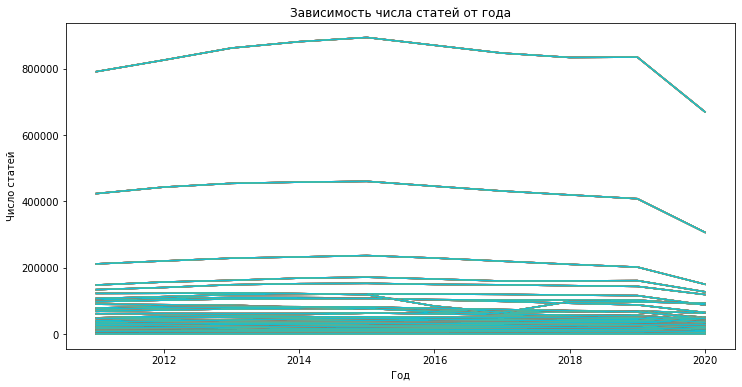

In [11]:
plt.figure(figsize=(12, 6))
for tag in data['tag']:
  plt.plot(data[data['tag']==tag]['year'], data[data['tag']==tag]['count'])
plt.title('Зависимость числа статей от года')
plt.xlabel('Год')
plt.ylabel('Число статей')
plt.show()

In [421]:
year_list = range(2012,2021)

In [109]:
data = pd.read_csv('/content/data (4).csv')

In [110]:
for tag in ['Messenger RNA vaccines', 'genetic testing', 'personalized cancer vaccines']:
  
  for year in year_list:
    count = pubmed.getTotalResultsCount(tag+' AND '+str(year))
    data =data.append([{'tag':tag, 'year':year, 'count':count}], ignore_index=True)
    time.sleep(0.5)


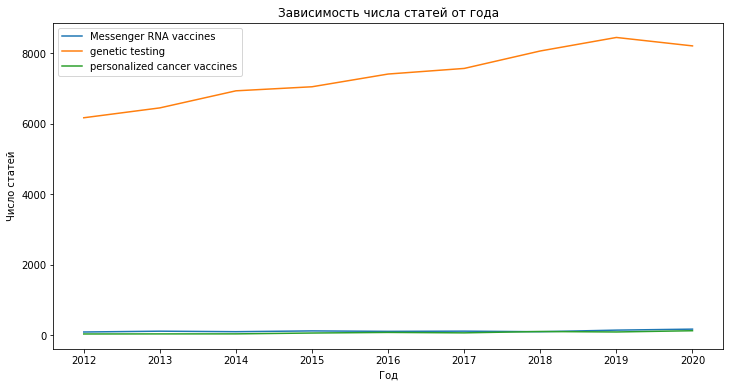

In [111]:
plt.figure(figsize=(12, 6))
for tag in ['Messenger RNA vaccines', 'genetic testing', 'personalized cancer vaccines']:
  plt.plot(data[data['tag']==tag]['year'], data[data['tag']==tag]['count'])
plt.title('Зависимость числа статей от года')
plt.xlabel('Год')
plt.ylabel('Число статей')
plt.legend(['Messenger RNA vaccines', 'genetic testing', 'personalized cancer vaccines'])
plt.show()

In [112]:
data.insert(3, 'delta', 0)

In [113]:
for i in tqdm(range(len(data))):
  if data.loc[i, 'year']>year_list[0]:
    tag = data.loc[i, 'tag']
    year = data.loc[i, 'year']-1
    pre = data.query('tag==@tag and year==@year')['count'].values
    data.loc[i, 'delta'] = data.loc[i, 'count'] - pre

100%|██████████| 10027/10027 [00:30<00:00, 331.14it/s]


In [114]:
data.head(20)

,tag,year,count,delta
0,"Team, Rapid Response",2011,172,0
1,"Team, Rapid Response",2012,207,0
2,"Team, Rapid Response",2013,231,24
3,"Team, Rapid Response",2014,292,61
4,"Team, Rapid Response",2015,286,-6
5,"Team, Rapid Response",2016,305,19
6,"Team, Rapid Response",2017,298,-7
7,"Team, Rapid Response",2018,289,-9
8,"Team, Rapid Response",2019,349,60
9,"Team, Rapid Response",2020,401,52


In [115]:
front_list=[]
for tag in tqdm(list(set(data['tag']))):
  flag = 0
  for year in year_list:
    if data.query('tag==@tag and year==@year')['delta'].values>0:
      flag +=1
    else:
      flag = 0
  if flag >=5:
    front_list.append(tag)
print(front_list)

100%|██████████| 1003/1003 [00:28<00:00, 35.43it/s]

['Blue, Methylene', 'Proof of Concept Evaluation', 'PAAD-DAPIN-PYRIN Domains', 'Photoelectron Spectroscopy, Xray', 'Eyes', 'Work Engagement', 'Necks', 'Studies, Interdisciplinary', 'Theories, Systems', 'DIPG, Diffuse Intrinsic Pontine Glioma', 'Synthetic Receptor', 'Perceptrons', 'Experimental Error, Scientific', 'Flame Retardant', 'Applications Softwares, Computer', 'Mandarin Orange Trees', 'Hydrogen Peroxide (H2O2)', 'Neurosciences, Social', 'Laboratory Critical Values', 'Vegan', 'Quality Data Reporting', 'Aland Islands', 'Non communicable Chronic Diseases', 'Freeze Dryings', 'Infiltrating Lymphocyte, Tumor', "Men's Role", 'Quality, Water', 'Acetylthiocholinesterase', 'Food Service', 'Temperatures, Melting Point', 'Mangrove Swamp', 'Application, Computer Software', 'Adenine Dinucleotide, Dihydronicotinamide']


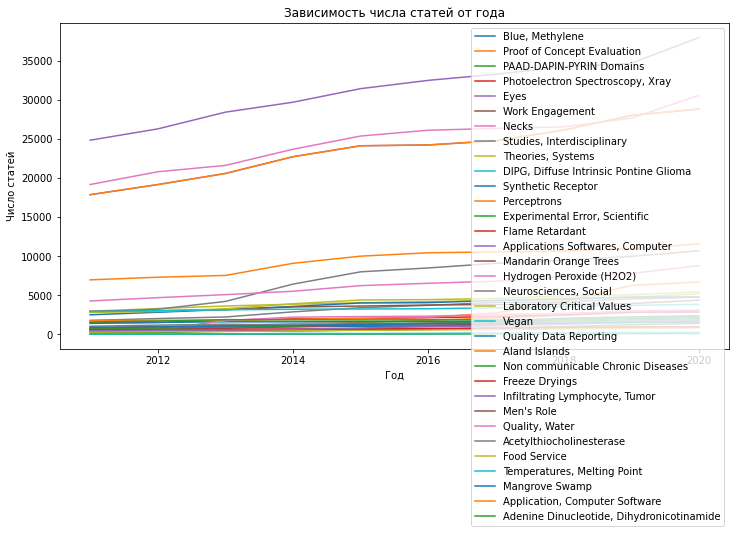

In [479]:
plt.figure(figsize=(12, 6))
for tag in front_list:
  plt.plot(data[data['tag']==tag]['year'], data[data['tag']==tag]['count'])
plt.title('Зависимость числа статей от года')
plt.xlabel('Год')
plt.ylabel('Число статей')
plt.legend(front_list)
plt.show()

In [15]:
data.head(50)

,tag,year,count,delta
0,"Team, Rapid Response",2011,172,0
1,"Team, Rapid Response",2012,207,0
2,"Team, Rapid Response",2013,231,24
3,"Team, Rapid Response",2014,292,61
4,"Team, Rapid Response",2015,286,-6
5,"Team, Rapid Response",2016,305,19
6,"Team, Rapid Response",2017,298,-7
7,"Team, Rapid Response",2018,289,-9
8,"Team, Rapid Response",2019,349,60
9,"Team, Rapid Response",2020,401,52


In [16]:
data.to_csv('data_2new.csv', index=False) 

In [480]:
data = pd.read_csv('data_2new.csv')

In [481]:
number_of_years=4
number_of_predicted_years=2

In [482]:
col_list_1 = ['tag']
col_list_2 =[]
col_list_3 =[]
col_list_4 = ['tag']
for i in range(1, number_of_years+1):
  col_list_1.append('year-'+str(i))
  col_list_1.append('year-'+str(i)+'_delta')
  col_list_4.append('year-'+str(i))
  col_list_4.append('year-'+str(i)+'_delta')
  col_list_2.append('year-'+str(i))

for i in range(0, number_of_predicted_years):
  col_list_1.append('year+'+str(i))
  col_list_1.append('year+'+str(i)+'_delta')
  
  col_list_2.append('year+'+str(i))
  col_list_3.append('year+'+str(i)+'_delta')
  

In [483]:
data_model= pd.DataFrame(columns=col_list_1)

In [484]:
data_model

,tag,year-1,year-1_delta,year-2,year-2_delta,year-3,year-3_delta,year-4,year-4_delta,year+0,year+0_delta,year+1,year+1_delta


In [485]:
i=0
for tag in list(set(data['tag'])):
  
  for year_first in range(year_list[0], year_list[0]+number_of_years-number_of_predicted_years+1):
    data_model =data_model.append({'tag':tag}, ignore_index=True)
    year_shift_list = range(year_first, year_first+number_of_years+number_of_predicted_years+1)
    for year, column in zip(year_shift_list, col_list_2):
      number = data.query('tag==@tag and year==@year')['count'].values[0]
      delta = data.query('tag==@tag and year==@year')['delta'].values[0]
      
      
      data_model.loc[i,column]= number
      data_model.loc[i,column+'_delta']= delta
      
    i+=1

In [486]:
data_model.head()

,tag,year-1,year-1_delta,year-2,year-2_delta,year-3,year-3_delta,year-4,year-4_delta,year+0,year+0_delta,year+1,year+1_delta
0,"Owl, Great Horned",70,0,78,8,78,0,92,14,91,-1,80,-11
1,"Owl, Great Horned",78,8,78,0,92,14,91,-1,80,-11,83,3
2,"Owl, Great Horned",78,0,92,14,91,-1,80,-11,83,3,83,0
3,Nucleotide,37412,0,38249,837,38801,552,38509,-292,36815,-1694,35237,-1578
4,Nucleotide,38249,837,38801,552,38509,-292,36815,-1694,35237,-1578,34685,-552


In [487]:
data_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3009 entries, 0 to 3008
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   tag           3009 non-null   object
 1   year-1        3009 non-null   object
 2   year-1_delta  3009 non-null   object
 3   year-2        3009 non-null   object
 4   year-2_delta  3009 non-null   object
 5   year-3        3009 non-null   object
 6   year-3_delta  3009 non-null   object
 7   year-4        3009 non-null   object
 8   year-4_delta  3009 non-null   object
 9   year+0        3009 non-null   object
 10  year+0_delta  3009 non-null   object
 11  year+1        3009 non-null   object
 12  year+1_delta  3009 non-null   object
dtypes: object(13)
memory usage: 305.7+ KB


In [488]:
data_model.insert(0, 'trend', 0)

In [489]:
for i in range(len(data_model)):
  flag =0
  for column in col_list_2[0:number_of_years]:
    if data_model.loc[i,column+'_delta']>0:
      flag+=1
  if flag ==number_of_years:
    data_model.loc[i,'trend']=1

In [490]:
data_model['trend'].value_counts()

0    2837
1     172
Name: trend, dtype: int64

In [491]:
data_model.insert(0, 'stable', 0)

In [492]:
for i in range(len(data_model)):
  flag =0
  for column in col_list_2[number_of_years:]:
    if data_model.loc[i,column+'_delta']>0:
      flag+=1
  if flag ==number_of_predicted_years and data_model.loc[i,'trend']==1:
    data_model.loc[i,'stable']=1

In [493]:
data_model['stable'].value_counts()

0    2926
1      83
Name: stable, dtype: int64

In [494]:
data_model[data_model['stable']==1]['tag'].unique()

array(['Survival, Cell', 'Blue, Methylene', 'Proof of Concept Evaluation',
       'PAAD-DAPIN-PYRIN Domains', 'Photoelectron Spectroscopy, Xray',
       'Eyes', 'Work Engagement', 'Necks', 'Studies, Interdisciplinary',
       'Marker, Immune', 'Model, Mental', 'Theories, Systems',
       'Neurolysis, Chemical', 'Perceptrons',
       'Experimental Error, Scientific', 'Flame Retardant', 'MDX-010',
       'Applications Softwares, Computer', 'Mandarin Orange Trees',
       'genetic testing', 'Hydrogen Peroxide (H2O2)',
       'Folding Disorders, Protein', 'Neurosciences, Social',
       'Laboratory Critical Values', 'Quality Data Reporting',
       'Maternal Child Nursing', 'Aland Islands', 'Commensalism',
       'Non communicable Chronic Diseases', 'Freeze Dryings',
       'Robotic-Assisted Surgery', 'Infiltrating Lymphocyte, Tumor',
       'Trajectories, Body-Weight', 'Cross-Sectional Analysis',
       "Men's Role", 'Quality, Water', 'Cognitive Rumination',
       'Critical Period, Psych

In [495]:
len(data_model[data_model['stable']==1]['tag'].unique())

45

In [496]:
data_model.insert(1, 'very_popular', 0)
data_model.insert(1, 'middle_popular', 0)

In [497]:
for i in range(len(data_model)):
  if data_model.loc[i, 'year-1']>15000:
    data_model.loc[i, 'very_popular']=1
  else:
    if data_model.loc[i, 'year+0']>3000:
      data_model.loc[i,'middle_popular']=1


In [498]:
list(data_model.query('stable==1 and very_popular==1 and trend==1')['tag'])

['Survival, Cell',
 'Survival, Cell',
 'Eyes',
 'Eyes',
 'Necks',
 'Necks',
 'Marker, Immune',
 'Marker, Immune',
 'Applications Softwares, Computer',
 'Applications Softwares, Computer',
 'Cross-Sectional Analysis',
 'Cross-Sectional Analysis',
 'Nuclear Medicine',
 'Nuclear Medicine',
 'Application, Computer Software',
 'Application, Computer Software']

In [306]:
data_model.to_csv('data_model.csv', index=False) 

In [260]:
data_model = pd.read_csv('/content/data_model (2).csv')

In [290]:
features=data_model.drop(col_list_2[number_of_years:]+col_list_3+['tag', 'stable'], axis =1)

In [291]:
features.head()

,middle_popular,very_popular,trend,year-1,year-1_delta,year-2,year-2_delta,year-3,year-3_delta,year-4,year-4_delta
0,0,0,0,70,0,78,8,78,0,92,14
1,0,0,0,78,8,78,0,92,14,91,-1
2,0,0,0,78,0,92,14,91,-1,80,-11
3,0,1,0,37412,0,38249,837,38801,552,38509,-292
4,0,1,0,38249,837,38801,552,38509,-292,36815,-1694


In [292]:
target = data_model['stable']

In [293]:
features_train_val, features_test, target_train_val, target_test = train_test_split(features, target, test_size = 0.2, random_state = SEED, shuffle = True)
#признаки и целевой признак разделяются на выборки
print(features_train_val.shape, features_test.shape, target_train_val.shape, target_test.shape)
#посмотрим на размеры получившихся выборок

(2407, 11) (602, 11) (2407,) (602,)


In [294]:
scaler = StandardScaler() #инициируем StandardScaler
scaler.fit(features_train_val) #обучаем на тренировочной выборке 
features_train_val= pd.DataFrame(scaler.transform(features_train_val), columns=features_train_val.columns) 
# создаем обратно датафреймы из преобразованных скейлером данных и старых названий столбцов
features_test= pd.DataFrame(scaler.transform(features_test), columns=features_test.columns)

In [102]:
def ranking(y, title='', xlabel='', ylabel=''):
    y_pos = np.arange(len(y),0,-1)
    plt.figure(figsize=(8,8))
    cmap = cm.viridis_r
    norm= colors.Normalize(0, np.max(abs(y.values)))
    bar_colors = cmap(abs(y.values/(np.max(y.values)-np.min(y.values))))
    
    plt.barh(y_pos, width=y, height=0.6, left=None, align='center', color=bar_colors, alpha = 0.8)
   
    plt.colorbar(cm.ScalarMappable(norm =norm, cmap=cmap))
    plt.yticks(y_pos, y.index)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    for p, c, ch in zip(y_pos, y.index, round(y,4)):
        plt.annotate(str(round(ch,4)), xy=(ch if ch>0 else 0, p), va='center')

In [295]:
def feature_importance(data_features, feature_importance, head_or_tail=''):
       
    importances = pd.DataFrame({'feature_importances':feature_importance}, index = data_features.columns)
    importances = importances.sort_values(by = 'feature_importances', ascending = False)
    if head_or_tail =='tail':
      importances = importances.tail(40)
    else: 
      importances = importances.head(40)

    ranking(importances['feature_importances'], title='Feature importance', xlabel='importance', ylabel='feature')

In [307]:
model = CatBoostClassifier(verbose = 500, eval_metric='F1', random_seed=SEED) #создаем модель CatBoostRegressor
model.fit(features_train_val, target_train_val) #обучаем модель на тренировочно-валидационной выборке
pred=model.predict(features_test)
print('f1_score={:.4f}'.format(f1_score(target_test, pred)))  #считаем и печатаем f1_score на тестовой выборке

Learning rate set to 0.014991
0:	learn: 0.3246753	total: 14.9ms	remaining: 14.9s
500:	learn: 0.9454545	total: 1.75s	remaining: 1.74s
999:	learn: 0.9956332	total: 3.47s	remaining: 0us
f1_score=0.6774


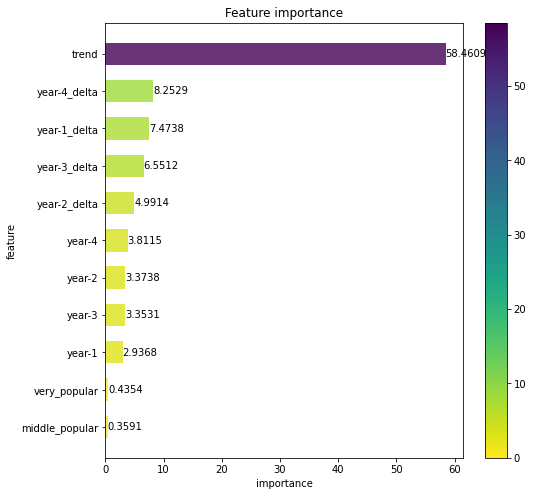

In [297]:
feature_importance(features_test, model.feature_importances_)
plt.savefig('feature_imp.jpg')

In [310]:
dump(model, 'model.joblib')

['model.joblib']

In [279]:
model = DummyClassifier(random_state=SEED) #создаем модель DummyClassifier - специальная "ничего не делающая" модель для сравнения результатов тестов.
model.fit(features_train_val, target_train_val) #обучаем модель на тренировочно-валидационной выборке
pred=model.predict(features_test)
print('f1_score={:.4f}'.format(f1_score(target_test, pred)))  #считаем и печатаем f1_score на тестовой выборке

f1_score=0.0333


/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [424]:
data_for_pred = pd.read_csv('data_2new.csv')

In [425]:
data_pred = pd.DataFrame(columns=col_list_4)

In [426]:
i=0
for tag in list(set(data_for_pred['tag'])):
  
  
  data_pred =data_pred.append({'tag':tag}, ignore_index=True)
  year_shift_list = range(year_list[-number_of_years-1], year_list[-1])
  for year, column in zip(year_shift_list, col_list_2):
    number = data_for_pred.query('tag==@tag and year==@year')['count'].values[0]
    delta = data_for_pred.query('tag==@tag and year==@year')['delta'].values[0]
      
      
    data_pred.loc[i,column]= number
    data_pred.loc[i,column+'_delta']= delta
      
  i+=1

In [427]:
data_pred.head()

,tag,year-1,year-1_delta,year-2,year-2_delta,year-3,year-3_delta,year-4,year-4_delta
0,"Owl, Great Horned",91,-1,80,-11,83,3,83,0
1,Nucleotide,36815,-1694,35237,-1578,34685,-552,35344,659
2,"Pregnancies, Unplanned",549,-18,506,-43,507,1,473,-34
3,Potassium Citrate,88,8,73,-15,80,7,83,3
4,"Somatosensory Area, Secondary",923,-26,928,5,917,-11,874,-43


In [428]:
data_pred.insert(0, 'trend', 0)

In [429]:
for i in range(len(data_pred)):
  flag =0
  for column in col_list_2[0:number_of_years]:
    if data_pred.loc[i,column+'_delta']>0:
      flag+=1
  if flag ==number_of_years:
    data_pred.loc[i,'trend']=1

In [430]:
data_pred['trend'].value_counts()

0    952
1     51
Name: trend, dtype: int64

In [431]:
data_pred.insert(1, 'very_popular', 0)
data_pred.insert(1, 'middle_popular', 0)

In [432]:
for i in range(len(data_pred)):
  if data_pred.loc[i, 'year-1']>15000:
    data_pred.loc[i, 'very_popular']=1
  else:
    if data_pred.loc[i, 'year-1']>3000:
      data_pred.loc[i,'middle_popular']=1

In [433]:
model=load('model.joblib')

In [434]:
pred = model.predict(data_pred.drop('tag', axis=1))

In [435]:
data_pred['prediction_stable']=pred

In [436]:
data_pred.query('prediction_stable==1 and very_popular==1 and trend==1')

,trend,middle_popular,very_popular,tag,year-1,year-1_delta,year-2,year-2_delta,year-3,year-3_delta,year-4,year-4_delta,prediction_stable


In [499]:
data_for_test=pd.DataFrame(columns={'tag', 'year', 'count'})

In [500]:
pubmed = pm.PubMed(tool="MyTool", email="njuts@ya.ru")

In [501]:
year_shift_list = range(year_list[-number_of_years-2], year_list[-1])

In [502]:
for tag in ['pregnant women']:
  
  for year in year_shift_list:
    count = pubmed.getTotalResultsCount(tag+' AND '+str(year))
    data_for_test =data_for_test.append([{'tag':tag, 'year':year, 'count':count}], ignore_index=True)
    time.sleep(0.5)


In [503]:
data_for_test

,count,year,tag
0,9672,2015,pregnant women
1,9757,2016,pregnant women
2,9469,2017,pregnant women
3,9649,2018,pregnant women
4,10148,2019,pregnant women


In [504]:
data_test = pd.DataFrame(columns=col_list_4)

In [505]:
i=0
year_shift_list = range(year_list[-number_of_years-1], year_list[-1])
for tag in list(set(data_for_test['tag'])):
  
  
  data_test =data_test.append({'tag':tag}, ignore_index=True)
  
  for year, column in zip(year_shift_list, col_list_2):
    number = data_for_test.query('tag==@tag and year==@year')['count'].values[0]
    delta = data_for_test.query('tag==@tag and year==@year')['count'].values[0]-data_for_test.query('tag==@tag and year==@year-1')['count'].values[0]
      
      
    data_test.loc[i,column]= number
    data_test.loc[i,column+'_delta']= delta
      
  i+=1

In [506]:
data_test

,tag,year-1,year-1_delta,year-2,year-2_delta,year-3,year-3_delta,year-4,year-4_delta
0,pregnant women,9757,85,9469,-288,9649,180,10148,499


In [507]:
data_test.insert(0, 'trend', 0)
data_test.insert(1, 'very_popular', 0)
data_test.insert(1, 'middle_popular', 0)

In [508]:
for i in range(len(data_test)):
  flag =0
  for column in col_list_2[0:number_of_years]:
    if data_test.loc[i,column+'_delta']>0:
      flag+=1
  if flag ==number_of_years:
    data_test.loc[i,'trend']=1

In [509]:
for i in range(len(data_test)):
  if data_test.loc[i, 'year-1']>15000:
    data_test.loc[i, 'very_popular']=1
  else:
    if data_test.loc[i, 'year-1']>3000:
      data_test.loc[i,'middle_popular']=1

In [510]:
model=load('model.joblib')

In [511]:
pred = model.predict(data_test.drop('tag', axis=1))

In [512]:
data_test['prediction_stable']=pred

In [513]:
data_test.query('prediction_stable==1 and very_popular==1 and trend==1')

,trend,middle_popular,very_popular,tag,year-1,year-1_delta,year-2,year-2_delta,year-3,year-3_delta,year-4,year-4_delta,prediction_stable


In [514]:
report=pd.DataFrame(columns=['trend', 'prediction_stable', 'very_popular', 'frontir'])

In [515]:
for i in range(len(data_test)):
  data_test =data_test.append({'tag':tag}, ignore_index=True)
  if data_test.loc[i,'trend']==1:
    trend ='Устойчивый рост за последние '+number_of_years+' лет'
  else:
    trend ='Отсутствует устойчивый рост'
  if data_test.loc[i,'prediction_stable']==1:
    stable = 'Прогноз устойчивости на ближайшие '+ str(number_of_predicted_years)+' лет'
  else:
    stable = 'Не предсказано устойчивости на ближайшие '+ str(number_of_predicted_years)+' лет'
  if data_test.loc[i,'very_popular']==1:
    very_popular = 'Тема с большим числом публикаций'
  else:
    if data_test.loc[i,'middle_popular']==1:
      very_popular = 'Тема со средним числом публикаций'
    else:
      very_popular ='Мало популярная тема'
  if data_test.loc[i,'prediction_stable']==1 and data_test.loc[i,'trend']==1 and data_test.loc[i,'very_popular']==1:
    frontir = 'Это фронтир!'
  else:
    frontir = 'Не является фронтиром'
report=report.append([{'trend':trend, 'prediction_stable':stable, 'very_popular':very_popular, 'frontir':frontir}])

In [516]:
report

,trend,prediction_stable,very_popular,frontir
0,Отсутствует устойчивый рост,Не предсказано устойчивости на ближайшие 2 лет,Тема со средним числом публикаций,Не является фронтиром


Мы уверены - наша система легко переносится на сайт, работу над которым мы уже начали, и легко масштабируется. В будущем нам хотелось бы анализировать с помощью нее не только отдельные запросы, но и целые разделы, а также распространить на другие научные направления. Сейчас наша модель обучена с применением небольшого количества данных, которые удалось получить за время хакатона. Обучение на других объемах данных даст возможность более гибко настраивать параметры, такие, как время предсказания
